## 7.3 LSTM进行中文新闻分类

**Daitu:2505131775@qq.com**

In [23]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [1]:
## 导入本章所需要的模块
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
## 输出图显示中文
from matplotlib.font_manager import FontProperties
fonts = FontProperties(fname = "/Library/Fonts/华文细黑.ttf")
import re
import string
import copy
import time
from sklearn.metrics import accuracy_score,confusion_matrix


import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as Data
import jieba
from torchtext import data
from torchtext.vocab import Vectors

## 中文数据预处理

数据去除不需要的字符、分词、去除停用词等操作

使用THUCNews的一个子集进行训练与测试，本次训练使用了其中的10个分类，每个分类6500条数据。

数据集划分如下：

训练集: 5000\*10

验证集: 500\*10

测试集: 1000\*10


In [2]:
## 读取训练、验证和测试数据集
train_df = pd.read_csv("data/chap7/cnews/cnews.train.txt",sep="\t",
                       header=None,names = ["label","text"])
val_df = pd.read_csv("data/chap7/cnews/cnews.val.txt",sep="\t",
                       header=None,names = ["label","text"])
test_df = pd.read_csv("data/chap7/cnews/cnews.test.txt",sep="\t",
                       header=None,names = ["label","text"])
train_df.head(5)

,label,text
0,体育,马晓旭意外受伤让国奥警惕 无奈大雨格外青睐殷家军记者傅亚雨沈阳报道 来到沈阳，国奥队依然没有...
1,体育,商瑞华首战复仇心切 中国玫瑰要用美国方式攻克瑞典多曼来了，瑞典来了，商瑞华首战求3分的信心也...
2,体育,冠军球队迎新欢乐派对 黄旭获大奖张军赢下PK赛新浪体育讯12月27日晚，“冠军高尔夫球队迎新...
3,体育,辽足签约危机引注册难关 高层威逼利诱合同笑里藏刀新浪体育讯2月24日，辽足爆发了集体拒签风波...
4,体育,揭秘谢亚龙被带走：总局电话骗局 复制南杨轨迹体坛周报特约记者张锐北京报道 谢亚龙已经被公安...


In [19]:
stop_words = pd.read_csv("data/chap7/cnews/中文停用词库.txt",
                         header=None,names = ["text"])

In [71]:
## 利用结巴并行分词
# jieba.enable_parallel(4)

In [72]:
## 对中文文本数据进行预处理，去除一些不需要的字符，分词，去停用词，等操作
def chinese_pre(text_data):
    ## 字母转化为小写,去除数字,
    text_data = text_data.lower()
    text_data = re.sub("\d+", "", text_data)
    ## 分词,使用精确模式
    text_data = list(jieba.cut(text_data,cut_all=False)) 
    ## 去停用词和多余空格
    text_data = [word.strip() for word in text_data if word not in stop_words.text.values]
    ## 处理后的词语使用空格连接为字符串
    text_data = " ".join(text_data)
    return text_data

In [55]:
## 对数据进行分词
train_df["cutword"] = train_df.text.apply(chinese_pre)
val_df["cutword"] = val_df.text.apply(chinese_pre)
test_df["cutword"] = test_df.text.apply(chinese_pre)

In [68]:
## 预处理后的结果保存为新的文件
train_df[["label","cutword"]].to_csv("data/chap7/cnews_train.csv",index=False)
val_df[["label","cutword"]].to_csv("data/chap7/cnews_val.csv",index=False)
test_df[["label","cutword"]].to_csv("data/chap7/cnews_test.csv",index=False)

In [77]:
train_df.cutword.head()

0    马晓旭 意外 受伤 国奥 警惕  无奈 大雨 格外 青睐 殷家 记者 傅亚雨 沈阳 报道  ...
1    商瑞华 首战 复仇 心切  中国 玫瑰 美国 方式 攻克 瑞典 多曼来 瑞典 商瑞华 首战 ...
2    冠军 球队 迎新 欢乐 派对  黄旭获 大奖 张军 pk 新浪 体育讯 冠军 高尔夫球 迎新...
3    辽足 签约 危机 注册 难关  高层 威逼利诱 合同 笑里藏刀 新浪 体育讯 辽足 爆发 集...
4    揭秘 谢亚龙 带走 总局 电话 骗局  复制 南杨 轨迹 体坛周报 特约记者 张锐 北京 报...
Name: cutword, dtype: object

In [2]:
train_df = pd.read_csv("data/chap7/cnews_train.csv")
val_df = pd.read_csv("data/chap7/cnews_val.csv")
test_df = pd.read_csv("data/chap7/cnews_test.csv")

In [3]:
labelMap = {"体育": 0,"娱乐": 1,"家居": 2,"房产": 3,"教育": 4,
            "时尚": 5,"时政": 6,"游戏": 7,"科技": 8,"财经": 9}
train_df["labelcode"] =train_df["label"].map(labelMap)
val_df["labelcode"] =val_df["label"].map(labelMap)
test_df["labelcode"] =test_df["label"].map(labelMap)
train_df.head()

,label,cutword,labelcode
0,体育,马晓旭 意外 受伤 国奥 警惕 无奈 大雨 格外 青睐 殷家 记者 傅亚雨 沈阳 报道 ...,0
1,体育,商瑞华 首战 复仇 心切 中国 玫瑰 美国 方式 攻克 瑞典 多曼来 瑞典 商瑞华 首战 ...,0
2,体育,冠军 球队 迎新 欢乐 派对 黄旭获 大奖 张军 pk 新浪 体育讯 冠军 高尔夫球 迎新...,0
3,体育,辽足 签约 危机 注册 难关 高层 威逼利诱 合同 笑里藏刀 新浪 体育讯 辽足 爆发 集...,0
4,体育,揭秘 谢亚龙 带走 总局 电话 骗局 复制 南杨 轨迹 体坛周报 特约记者 张锐 北京 报...,0


In [4]:
train_df[["labelcode","cutword"]].to_csv("data/chap7/cnews_train2.csv",index=False)
val_df[["labelcode","cutword"]].to_csv("data/chap7/cnews_val2.csv",index=False)
test_df[["labelcode","cutword"]].to_csv("data/chap7/cnews_test2.csv",index=False)

### 使用torchtext库准备网络需要的数据

In [6]:
## 使用torchtext库进行数据准备
# 定义文件中对文本和标签所要做的操作
"""
sequential=True:表明输入的文本时字符，而不是数值字
tokenize="spacy":使用spacy切分词语
use_vocab=True: 创建一个词汇表
batch_first=True: batch优先的数据方式
fix_length=400 :每个句子固定长度为400
"""
## 定义文本切分方法，因为前面已经做过处理，所以直接使用空格切分即可
mytokenize = lambda x: x.split()
TEXT = data.Field(sequential=True, tokenize=mytokenize, 
                  include_lengths=True, use_vocab=True,
                  batch_first=True, fix_length=400)
LABEL = data.Field(sequential=False, use_vocab=False, 
                   pad_token=None, unk_token=None)
## 对所要读取的数据集的列进行处理
text_data_fields = [
    ("labelcode", LABEL), # 对标签的操作
    ("cutword", TEXT) # 对文本的操作
]
## 读取数据
traindata,valdata,testdata = data.TabularDataset.splits(
    path="data/chap7", format="csv", 
    train="cnews_train2.csv", fields=text_data_fields, 
    validation="cnews_val2.csv",
    test = "cnews_test2.csv", skip_header=True
)

In [7]:
len(traindata),len(valdata),len(testdata)

(50000, 5000, 10000)

In [8]:
## 检查一个样本的标签和文本
em = traindata.examples[0]
print(em.labelcode)
print(em.cutword)

0
['马晓旭', '意外', '受伤', '国奥', '警惕', '无奈', '大雨', '格外', '青睐', '殷家', '记者', '傅亚雨', '沈阳', '报道', '来到', '沈阳', '国奥队', '依然', '没有', '摆脱', '雨水', '困扰', '下午', '国奥队', '日常', '训练', '再度', '大雨', '干扰', '无奈', '之下', '队员', '慢跑', '分钟', '草草收场', '上午', '国奥队', '奥体中心', '外场', '训练', '阴沉沉', '气象预报', '显示', '当天', '下午', '沈阳', '大雨', '幸好', '队伍', '上午', '训练', '没有', '干扰', '下午', '球队', '抵达', '训练场', '大雨', '已经', '几个', '小时', '丝毫', '没有', '停下来', '意思', '试一试', '态度', '球队', '当天', '下午', '例行', '训练', '分钟', '过去', '天气', '没有', '转好', '迹象', '保护', '球员', '国奥队', '决定', '中止', '当天', '训练', '全队', '立即', '返回', '酒店', '训练', '足球队', '稀罕', '奥运会', '即将', '之前', '全队', '变得', '娇贵', '沈阳', '最后', '一周', '训练', '国奥队', '保证', '现有', '球员', '不再', '出现意外', '伤病', '情况', '影响', '正式', '比赛', '这一', '阶段', '控制', '训练', '受伤', '控制', '感冒', '疾病', '出现', '队伍', '放在', '相当', '重要', '位置', '抵达', '沈阳', '之后', '后卫', '冯萧霆', '一直', '没有', '训练', '冯萧霆', '长春', '患上', '感冒', '没有', '参加', '塞尔维亚', '热身赛', '队伍', '介绍', '冯萧霆', '没有', '出现', '发烧', '症状', '安全', '两天', '静养', '休息', '感冒', '彻底', '之后', '恢复', '训练', '冯萧霆', '例子', '国奥

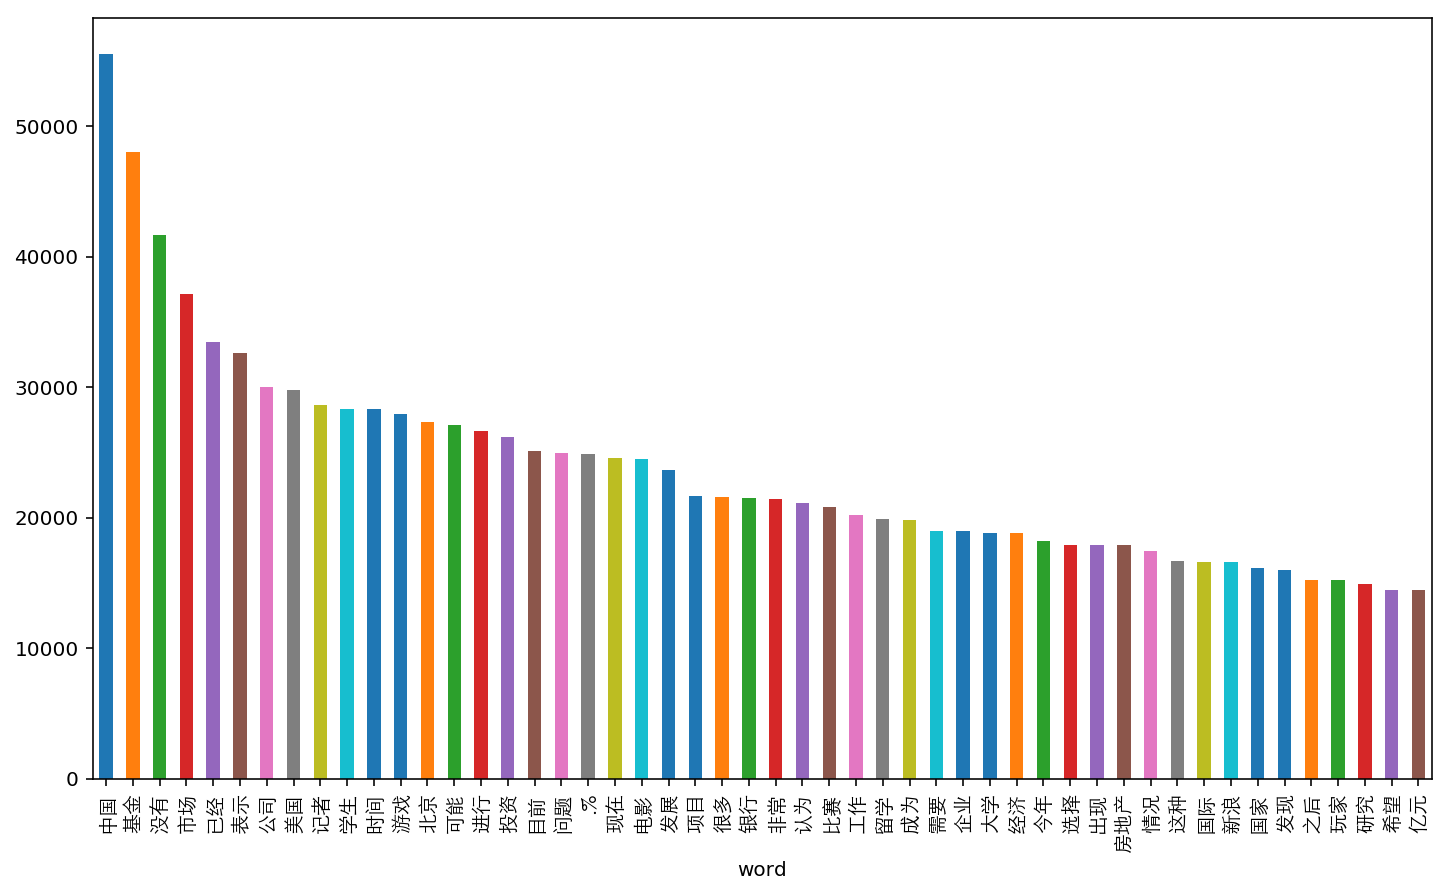

词典的词数: 20002
前10个单词:
 ['<unk>', '<pad>', '中国', '基金', '没有', '市场', '已经', '表示', '公司', '美国']
类别标签情况: Counter({'6': 5000, '8': 5000, '9': 5000, '2': 5000, '3': 5000, '4': 5000, '7': 5000, '1': 5000, '5': 5000, '0': 5000})


In [31]:
## 使用训练集构建单词表,没有预训练好的词项量
TEXT.build_vocab(traindata,max_size=20000,vectors = None)
LABEL.build_vocab(traindata)
## 可视化训练集中的前50个高频词
word_fre = TEXT.vocab.freqs.most_common(n=50)
word_fre = pd.DataFrame(data=word_fre,columns=["word","fre"])
word_fre.plot(x="word", y="fre", kind="bar",legend=False,figsize=(12,7))
plt.xticks(rotation = 90,fontproperties = fonts,size = 10)
plt.show()

print("词典的词数:",len(TEXT.vocab.itos))
print("前10个单词:\n",TEXT.vocab.itos[0:10])
## 类别标签的数量和类别
print("类别标签情况:",LABEL.vocab.freqs)

In [11]:
## 定义一个迭代器，将类似长度的示例一起批处理。
BATCH_SIZE = 64
train_iter = data.BucketIterator(traindata,batch_size = BATCH_SIZE)
val_iter = data.BucketIterator(valdata,batch_size = BATCH_SIZE)
test_iter = data.BucketIterator(testdata,batch_size = BATCH_SIZE)

In [12]:
##  获得一个batch的数据，对数据进行内容进行介绍
for step, batch in enumerate(train_iter):  
    if step > 0:
        break
## 针对一个batch 的数据，可以使用batch.labelcode获得数据的类别标签
print("数据的类别标签:\n",batch.labelcode)
## batch.cutword[0]是文本对应的标签向量
print("数据的尺寸:",batch.cutword[0].shape)
## batch.cutword[1] 对应每个batch使用的原始数据中的索引
print("数据样本数:",len(batch.cutword[1]))

数据的类别标签:
 tensor([0, 8, 6, 5, 4, 5, 8, 9, 5, 8, 7, 8, 0, 2, 1, 9, 0, 5, 2, 4, 8, 3, 9, 8,
        1, 4, 7, 7, 8, 7, 2, 8, 2, 8, 1, 2, 9, 1, 6, 5, 1, 0, 6, 3, 3, 0, 0, 6,
        1, 7, 1, 7, 6, 4, 6, 1, 4, 8, 8, 2, 8, 5, 0, 0])
数据的尺寸: torch.Size([64, 400])
数据样本数: 64


In [13]:
##  获得一个batch的数据，对数据进行内容进行介绍
for step, batch in enumerate(train_iter):  
    textdata,target = batch.cutword[0],batch.labelcode.view(-1)
    if step > 0:
        break
# ## 针对一个batch 的数据，可以使用batch.labelcode获得数据的类别标签
# print("数据的类别标签:\n",batch.labelcode)
# ## batch.cutword[0]是文本对应的标签向量
# print("数据的尺寸:",batch.cutword[0].shape)
# ## batch.cutword[1] 对应每个batch使用的原始数据中的索引
# print("数据样本数:",len(batch.cutword[1]))

## LSTM网络

In [14]:
class LSTMNet(nn.Module):
    def __init__(self, vocab_size,embedding_dim, hidden_dim, layer_dim, output_dim):
        """
        vocab_size:词典长度
        embedding_dim:词向量的维度
        hidden_dim: RNN神经元个数
        layer_dim: RNN的层数
        output_dim:隐藏层输出的维度(分类的数量)
        """
        super(LSTMNet, self).__init__()
        self.hidden_dim = hidden_dim ## RNN神经元个数
        self.layer_dim = layer_dim ## RNN的层数
        ## 对文本进行词项量处理
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # LSTM ＋ 全连接层
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, layer_dim,
                            batch_first=True)
        self.fc1 = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        embeds = self.embedding(x)
        # r_out shape (batch, time_step, output_size)
        # h_n shape (n_layers, batch, hidden_size)   LSTM 有两个 hidden states, h_n 是分线, h_c 是主线
        # h_c shape (n_layers, batch, hidden_size)
        r_out, (h_n, h_c) = self.lstm(embeds, None)   # None 表示 hidden state 会用全0的 state
        # 选取最后一个时间点的out输出
        out = self.fc1(r_out[:, -1, :]) 
        return out
    

In [15]:
vocab_size = len(TEXT.vocab)
embedding_dim = 100
hidden_dim = 128
layer_dim = 1
output_dim = 10
lstmmodel = LSTMNet(vocab_size, embedding_dim, hidden_dim, layer_dim, output_dim)
lstmmodel

LSTMNet(
  (embedding): Embedding(20002, 100)
  (lstm): LSTM(100, 128, batch_first=True)
  (fc1): Linear(in_features=128, out_features=10, bias=True)
)

In [16]:
## 定义网络的训练过程函数
def train_model2(model,traindataloader, valdataloader,criterion, 
                 optimizer,num_epochs=25,):
    """
    model:网络模型；traindataloader:训练数据集;
    valdataloader:验证数据集，;criterion：损失函数；optimizer：优化方法；
    num_epochs:训练的轮数
    """
    train_loss_all = []
    train_acc_all = []
    val_loss_all = []
    val_acc_all = []
    since = time.time()
    for epoch in range(num_epochs):
        print('-' * 10)
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        # 每个epoch有两个阶段,训练阶段和验证阶段
        train_loss = 0.0
        train_corrects = 0
        train_num = 0
        val_loss = 0.0
        val_corrects = 0
        val_num = 0
        model.train() ## 设置模型为训练模式
        for step,batch in enumerate(traindataloader):
            textdata,target = batch.cutword[0],batch.labelcode.view(-1)
            out = model(textdata)
            pre_lab = torch.argmax(out,1) # 预测的标签
            loss = criterion(out, target) # 计算损失函数值
            optimizer.zero_grad()        
            loss.backward()       
            optimizer.step()  
            train_loss += loss.item() * len(target)
            train_corrects += torch.sum(pre_lab == target.data)
            train_num += len(target)
        ## 计算一个epoch在训练集上的损失和精度
        train_loss_all.append(train_loss / train_num)
        train_acc_all.append(train_corrects.double().item()/train_num)
        print('{} Train Loss: {:.4f}  Train Acc: {:.4f}'.format(
            epoch, train_loss_all[-1], train_acc_all[-1]))
        
        ## 计算一个epoch的训练后在验证集上的损失和精度
        model.eval() ## 设置模型为训练模式评估模式 
        for step,batch in enumerate(valdataloader):
            textdata,target = batch.cutword[0],batch.labelcode.view(-1)
            out = model(textdata)
            pre_lab = torch.argmax(out,1)
            loss = criterion(out, target)   
            val_loss += loss.item() * len(target)
            val_corrects += torch.sum(pre_lab == target.data)
            val_num += len(target)
        ## 计算一个epoch在训练集上的损失和精度
        val_loss_all.append(val_loss / val_num)
        val_acc_all.append(val_corrects.double().item()/val_num)
        print('{} Val Loss: {:.4f}  Val Acc: {:.4f}'.format(
            epoch, val_loss_all[-1], val_acc_all[-1]))
    train_process = pd.DataFrame(
        data={"epoch":range(num_epochs),
              "train_loss_all":train_loss_all,
              "train_acc_all":train_acc_all,
              "val_loss_all":val_loss_all,
              "val_acc_all":val_acc_all})  
    return model,train_process

In [18]:
# 定义优化器
optimizer = torch.optim.Adam(lstmmodel.parameters(), lr=0.0003)  
loss_func = nn.CrossEntropyLoss()   # 损失函数
## 对模型进行迭代训练,对所有的数据训练EPOCH轮
lstmmodel,train_process = train_model2(
    lstmmodel,train_iter,val_iter,loss_func,optimizer,num_epochs=20)

----------
Epoch 0/19
0 Train Loss: 2.2525  Train Acc: 0.1398
0 Val Loss: 2.2883  Val Acc: 0.1370
----------
Epoch 1/19
1 Train Loss: 2.1228  Train Acc: 0.2151
1 Val Loss: 2.2096  Val Acc: 0.2218
----------
Epoch 2/19
2 Train Loss: 1.6153  Train Acc: 0.3810
2 Val Loss: 1.7338  Val Acc: 0.4082
----------
Epoch 3/19
3 Train Loss: 1.1585  Train Acc: 0.5932
3 Val Loss: 1.2594  Val Acc: 0.5766
----------
Epoch 4/19
4 Train Loss: 0.7758  Train Acc: 0.7671
4 Val Loss: 0.8544  Val Acc: 0.7348
----------
Epoch 5/19
5 Train Loss: 0.6044  Train Acc: 0.8278
5 Val Loss: 0.8486  Val Acc: 0.7424
----------
Epoch 6/19
6 Train Loss: 0.5018  Train Acc: 0.8606
6 Val Loss: 0.7000  Val Acc: 0.7948
----------
Epoch 7/19
7 Train Loss: 0.3674  Train Acc: 0.8974
7 Val Loss: 0.5616  Val Acc: 0.8348
----------
Epoch 8/19
8 Train Loss: 0.3364  Train Acc: 0.9079
8 Val Loss: 0.5042  Val Acc: 0.8472
----------
Epoch 9/19
9 Train Loss: 0.2484  Train Acc: 0.9321
9 Val Loss: 0.4599  Val Acc: 0.8656
----------
Epoch 10/

In [19]:
## 输出结果保存和数据保存
torch.save(lstmmodel,"data/chap7/lstmmodel.pkl")
## 导入保存的模型
lstmmodel = torch.load("data/chap7/lstmmodel.pkl")
lstmmodel
## 保存训练过程
train_process.to_csv("data/chap7/lstmmodel_process.csv",index=False)
train_process

/Users/daitu/anaconda3/envs/python35/lib/python3.5/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type LSTMNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


,epoch,train_acc_all,train_loss_all,val_acc_all,val_loss_all
0,0,0.13980,2.252489,0.1370,2.288265
1,1,0.21510,2.122767,0.2218,2.209593
2,2,0.38100,1.615332,0.4082,1.733787
3,3,0.59316,1.158519,0.5766,1.259442
4,4,0.76708,0.775829,0.7348,0.854391
5,5,0.82776,0.604446,0.7424,0.848647
6,6,0.86060,0.501788,0.7948,0.699981
7,7,0.89736,0.367413,0.8348,0.561573
8,8,0.90788,0.336408,0.8472,0.504159
9,9,0.93214,0.248354,0.8656,0.459921


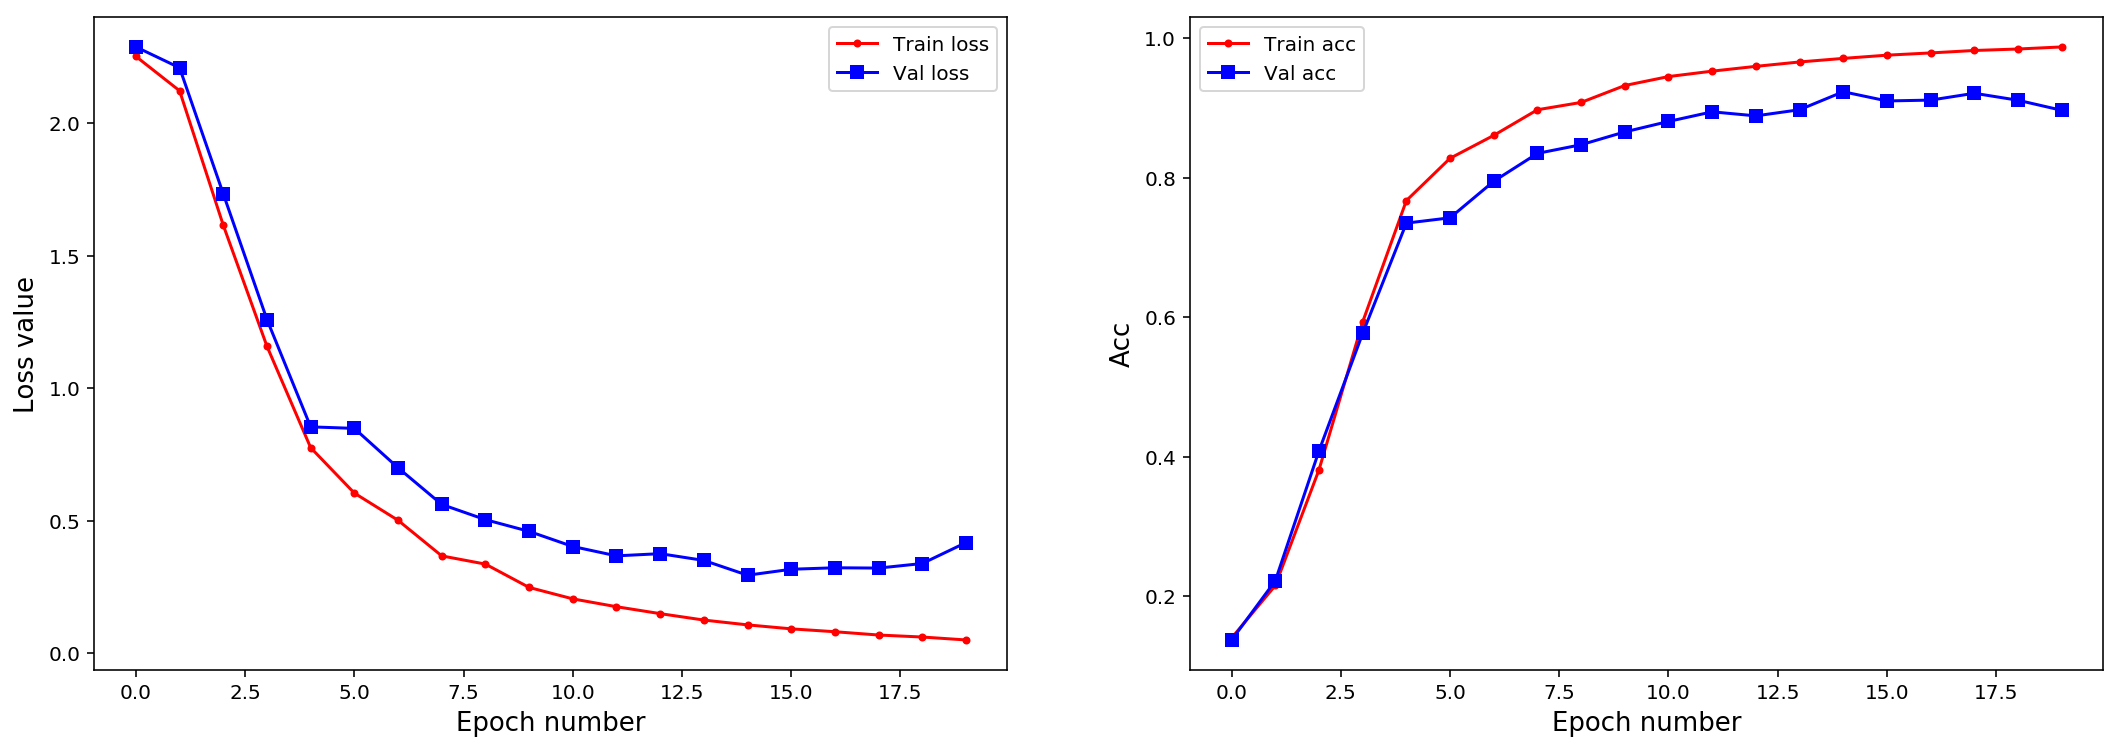

In [28]:
## 可视化模型训练过程中
plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
plt.plot(train_process.epoch,train_process.train_loss_all,
         "r.-",label = "Train loss")
plt.plot(train_process.epoch,train_process.val_loss_all,
         "bs-",label = "Val loss")
plt.legend()
plt.xlabel("Epoch number",size = 13)
plt.ylabel("Loss value",size = 13)
plt.subplot(1,2,2)
plt.plot(train_process.epoch,train_process.train_acc_all,
         "r.-",label = "Train acc")
plt.plot(train_process.epoch,train_process.val_acc_all,
         "bs-",label = "Val acc")
plt.xlabel("Epoch number",size = 13)
plt.ylabel("Acc",size = 13)
plt.legend()
plt.show()

在测试集上的预测精度为: 0.9322


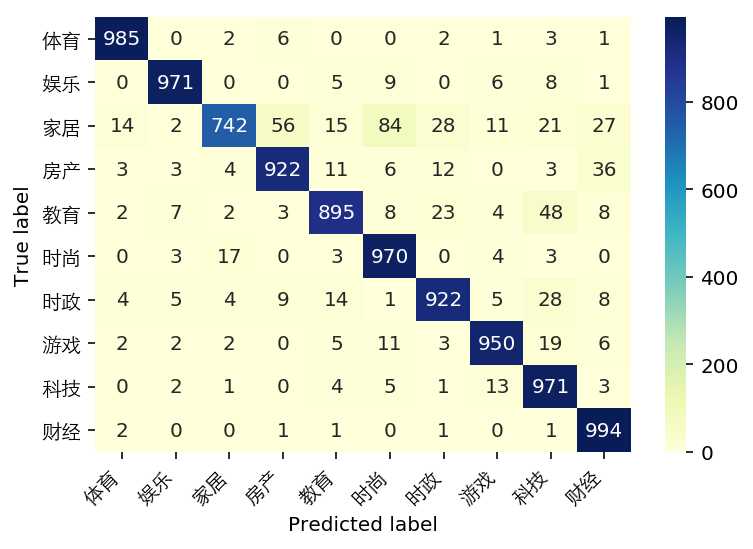

In [29]:
## 对测试集进行预测并计算精度
lstmmodel.eval() ## 设置模型为训练模式评估模式 
test_y_all = torch.LongTensor()
pre_lab_all = torch.LongTensor()
for step,batch in enumerate(test_iter):
    textdata,target = batch.cutword[0],batch.labelcode.view(-1)
    out = lstmmodel(textdata)
    pre_lab = torch.argmax(out,1)
    test_y_all = torch.cat((test_y_all,target)) ##测试集的标签
    pre_lab_all = torch.cat((pre_lab_all,pre_lab))##测试集的预测标签

acc = accuracy_score(test_y_all,pre_lab_all)
print("在测试集上的预测精度为:",acc)
## 计算混淆矩阵并可视化
class_label = ["体育","娱乐","家居","房产","教育",
               "时尚","时政","游戏","科技","财经"]
conf_mat = confusion_matrix(test_y_all,pre_lab_all)
df_cm = pd.DataFrame(conf_mat, index=class_label, columns=class_label)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d",cmap="YlGnBu")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0,
                             ha='right',fontproperties = fonts)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45,
                             ha='right',fontproperties = fonts)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

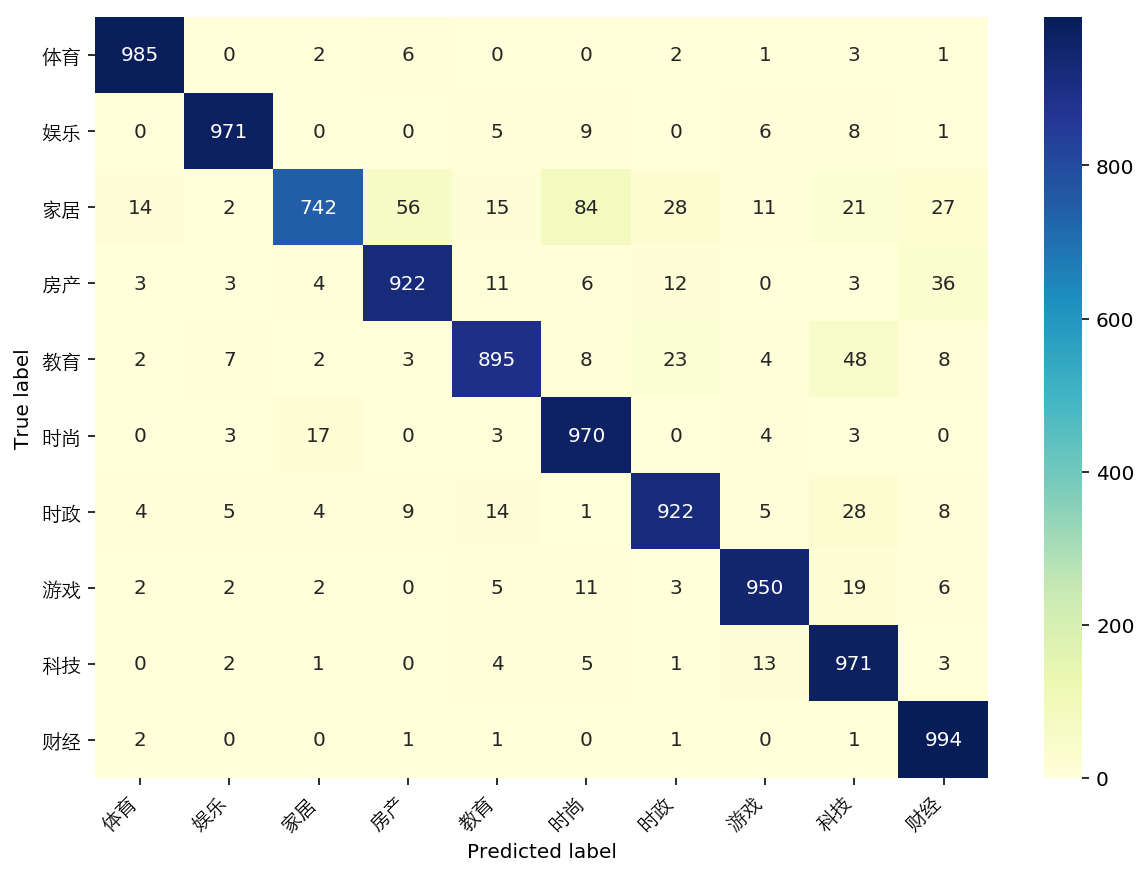

In [30]:
plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_cm, annot=True, fmt="d",cmap="YlGnBu")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0,
                             ha='right',fontproperties = fonts)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45,
                             ha='right',fontproperties = fonts)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()